In [1]:
#import axion_ppa
import ppa
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy.linalg as nl
import scipy.linalg as sl
import mpmath

mpmath.mp.dps=30
print(mpmath.mp)


import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import scipy.constants as sc
from astropy.time import Time
from scipy.sparse import bmat


plt.rc('font',**{'family':'serif','serif':['Times']})
mpl.rcParams['font.size'] = 13
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 1

# Changing this will affect the size of the plot in Jupyter notebook as well as resolution of the final PDF. Can change later
plt.rcParams['figure.dpi'] = 100

# tick parameters:
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True


mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
    
mpl.rcParams['xtick.major.size'] = 6  # default 3.5
mpl.rcParams['ytick.major.size'] = 6  # default 3.5
mpl.rcParams['xtick.minor.size'] =  3  # default 2 
mpl.rcParams['ytick.minor.size'] = 3  # default 2 
    
mpl.rcParams['xtick.major.width'] = 1  # default 0.8
mpl.rcParams['ytick.major.width'] = 1  # default 0.8
mpl.rcParams['xtick.minor.width'] =1  # default 0.6
mpl.rcParams['ytick.minor.width'] = 1  # default 0.6



PSR_DICT= ppa.Load_All_Pulsar_Info()
PSR_NAME_LIST = list(PSR_DICT.keys())

Mpmath settings:
  mp.prec = 103               [default: 53]
  mp.dps = 30                 [default: 15]
  mp.trap_complex = False     [default: False]


In [2]:

pulsars = []
subset="10cm"
for psrn in PSR_DICT:
    if psrn in ["J0437-4715" ]:
        pulsars.append(ppa.Pulsar(PSR_DICT[psrn],iono="subt",order=2,subset=subset,nfreqs_dict={"10cm":5,"20cm":0}))
    elif psrn in [ "J1022+1001" , "J1713+0747" , "J1909-3744"]:
        pulsars.append(ppa.Pulsar(PSR_DICT[psrn],iono="subt",order=2,subset=subset,nfreqs_dict={"10cm":30,"20cm":0}))
    else:
        pulsars.append(ppa.Pulsar(PSR_DICT[psrn],iono="subt",order=2,subset=subset,nfreqs_dict={"10cm":0,"20cm":0}))

#pulsars = [ppa.Pulsar(PSR_DICT[psrn],iono="subt",order=2,subset="20cm",nfreqs_dict={"10cm":30,"20cm":30}) for psrn in PSR_DICT]
#pulsars = [ppa.Pulsar(PSR_DICT[psrn],iono="none",order=2,subset=["10cm"],nfreqs=1) for psrn in PSR_DICT]

# pulsars1 = [p for p in pulsars1 if len(p.SUBSETS)>0]
# pulsars = [p for p in pulsars if len(p.SUBSETS)>0]
# for i in range(19):
#     psr1 = pulsars1[i]
#     psr0 = pulsars[i]
#     print( "%.4f"%np.std(psr1.DPA[0]) , "%.4f"%np.std(psr0.DPA[0]) )

array = ppa.Array(pulsars)
lnlike0 = array.Generate_Lnlike_Function("none")
lnlike1 = array.Generate_Lnlike_Function("auto")
lnlike2 = array.Generate_Lnlike_Function("full")


NPSR = array.NPSR
NSS = array.NSUBSETS_TOTAL
print(NPSR,NSS)


def Mapper(params):

    l10_EFAC = params[:NSS]
    l10_EQUAD = params[NSS:2*NSS]
    l10_S0 = params[2*NSS:3*NSS]
    Gamma = params[3*NSS:4*NSS]
    sDTE = params[4*NSS : 4*NSS+NPSR]
    l10_ma = params[4*NSS+NPSR ]
    l10_Sa = params[4*NSS+NPSR + 1]

    return l10_EFAC , l10_EQUAD , l10_S0 , Gamma , sDTE  , l10_ma , l10_Sa

all10 = []
for i in range(len(array.PSR_NAMES)):
    if PSR_NAME_LIST[i] in array.PSR_NAMES:
        all10.append(i)
#print(all10)

init = [ *array.Load_bestfit_params() , np.ones(NPSR),-22.,-3]
lnlike2(*init)

22 22


15143.320507095046

In [3]:
print(lnlike0(*init))
print(lnlike1(*init))
print(lnlike2(*init))

15143.373495888403
15143.917069184175
15143.320507095046


In [8]:
%timeit lnlike2(*init)

18.4 ms ± 804 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Mock Data test

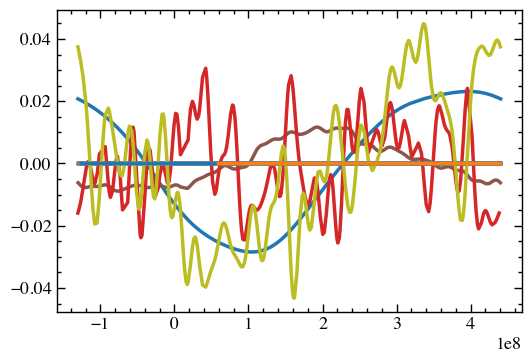

In [6]:
# red background comparison
DPA1 = array.Gen_Mock_Data(noise_type='red',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )

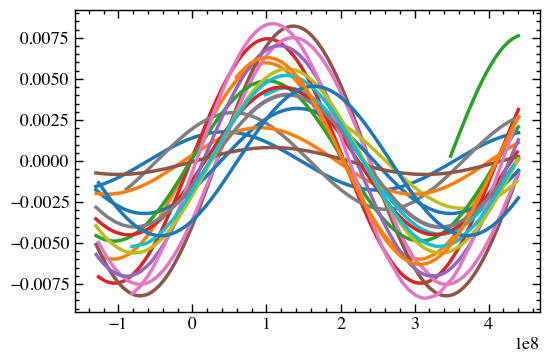

In [5]:
# white background, full signal
DPA1 = array.Gen_Mock_Data(noise_type='white',adm_signal='full',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )

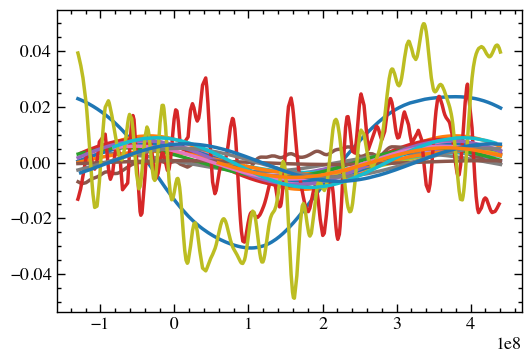

In [7]:
# another comparison
DPA1 = array.Gen_Mock_Data(noise_type='red',adm_signal='full',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=12)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )

# This is to read chain

In [40]:
for i ,n in enumerate(array.PSR_NAMES):
    print(i,n)


0 J0437-4715
1 J0613-0200
2 J0614-3329
3 J0711-6830
4 J1017-7156
5 J1022+1001
6 J1024-0719
7 J1045-4509
8 J1125-6014
9 J1545-4550
10 J1600-3053
11 J1603-7202
12 J1643-1224
13 J1713+0747
14 J1730-2304
15 J1744-1134
16 J1824-2452
17 J1857+0943
18 J1909-3744
19 J1939+2134
20 J2145-0750
21 J2241-5236


505


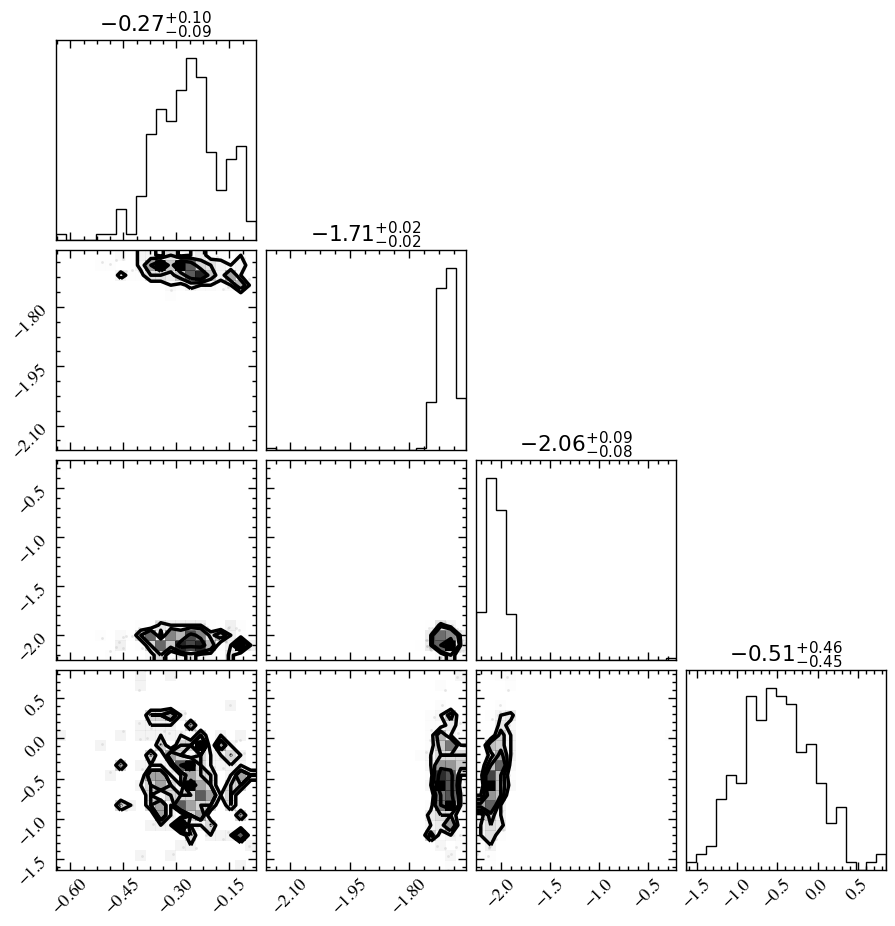

In [49]:
import corner
ipsr = 13
chain = np.loadtxt("Signal_Chain/mock_red_se22_ana_d0_o2_r-1_isubt_10cm_nf_Np22/bin_-23.25_-23.15/chain_1.txt")
print(len(chain))
corner.corner(chain[300:,[1+ipsr,1+22+ipsr,1+22+22+ipsr , 1+22+22+22+ipsr]],show_titles=True);

# Test individual pulsar

In [ ]:
array1 = ppa.Array(pulsars1)
array0 = ppa.Array(pulsars)
NPSR = array0.NPSR
plt.subplots(NPSR,1,figsize=(6,5*NPSR),sharex=True,sharey=True)
for i in range(NPSR):
    plt.subplot(NPSR,1,i+1)
    plt.plot(array0.TOA[i][0] , array0.DPA[i][0],'.',label="original")
    plt.plot(array1.TOA[i][0] , array1.DPA[i][0],'.',label="ionFR subtraction")
    plt.ylim(-np.pi/4,np.pi/4)
    plt.annotate(array0.PSR_NAMES[i],xy=(0.1,0.1),xycoords="axes fraction")
    plt.xlim(-2100,5500)
    plt.legend(loc=1)
plt.savefig("ionFR.jpg",bbox_inches='tight')

NameError: name 'pulsars' is not defined

In [ ]:
pulsars1 = [ppa.Pulsar(PSR_DICT[psrn],iono="Subt",order=2,subset="10cm") for psrn in PSR_DICT]
pulsars = [ppa.Pulsar(PSR_DICT[psrn],iono="None",order=2,subset="10cm") for psrn in PSR_DICT]
array = ppa.Array(pulsars1)
test1 = array.Gen_White_Mock_Data()


lnlike = array.Generate_Lnlike_Function(method="Auto")
#lnlike( np.zeros(22+26) , np.ones(22+26)*-10 , np.ones(27) , -22,-10  )

In [ ]:
NPSR = 19
NSS = 19
groups = [np.arange(19*3+3) , [0, 2*NSS+NPSR+1 , 2*NSS+NPSR + 2  ]]

iss = 1
groups = []
for ipsr in range(NPSR):
    g = []
    nss = len( array.SUBSETS[ipsr] )
    g += np.arange(iss,iss+nss).tolist()
    g += np.arange(iss+NSS,iss+nss+NSS).tolist()
    g += [1+2*NSS+ipsr]
    iss += nss
    groups.append(g)
groups

[[1, 20, 39],
 [2, 21, 40],
 [3, 22, 41],
 [4, 23, 42],
 [5, 24, 43],
 [6, 25, 44],
 [7, 26, 45],
 [8, 27, 46],
 [9, 28, 47],
 [10, 29, 48],
 [11, 30, 49],
 [12, 31, 50],
 [13, 32, 51],
 [14, 33, 52],
 [15, 34, 53],
 [16, 35, 54],
 [17, 36, 55],
 [18, 37, 56],
 [19, 38, 57]]